In [60]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.optimize import curve_fit
import multiprocessing.pool


### Lab Measures

In [61]:
# Metrix
C_metrix = 671e-12
R_metrix = 26.95
RL_metrix = 9.96

#From previous measurements
Rg = 48.8
L = 350.0e-6

Rtot = R_metrix + Rg + RL_metrix
print("Rtot = ", Rtot)

Rtot =  85.71000000000001


### Expected Results

In [62]:
Q = 1.0/Rtot*np.sqrt(L/C_metrix)
print("Q = ", Q)
f0 = 1/(2*np.pi)*np.sqrt(1/(L*C_metrix))
print("f0 = ", f0*1e-3, "kHz")

Q =  8.426384396740353
f0 =  328.4164099829851 kHz


In [63]:
1/np.sqrt(3)

np.float64(0.5773502691896258)

### Input Processing

In [64]:
project_name = "RLC_freq"

data = np.genfromtxt(f'../input/{project_name}.csv', delimiter=';', skip_header=1)
f_data, Vin_data, Vout_data , Vin_div, Vout_div, t_data, t_div= data.T
Tr_data = Vout_data/Vin_data

phi_data = 2*np.pi*f_data*np.array(t_data)*1e-6/(np.pi/2.) # norm to 1
phi_div = 2*np.pi*f_data*np.array(t_div)*1e-6/(np.pi/2.)



### Errors

In [65]:
err_readingV = 0.1*0.41
err_scaleV = 0.03*0.41
Vout_err = err_readingV*Vout_div
Vin_err = err_readingV*Vin_div
phi_err = 0.1*phi_div*0.41
Tr_err = Tr_data * np.sqrt((Vout_err/Vout_data)**2 + (Vin_err/Vin_data)**2+2*(err_scaleV)**2)


### Plot Params

In [66]:
plt.style.use('seaborn-v0_8-whitegrid') 
params = {
    'figure.figsize': (8, 6),
    'axes.labelsize': 12,
    'figure.titlesize': 16,
    'axes.titlesize': 14,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'lines.linewidth': 1.5,
    'lines.markersize': 4,
    'legend.fontsize': 11,
    'legend.framealpha': 0.8,
    'legend.loc': 'best',
    'figure.dpi': 120,
    'savefig.dpi': 150,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.5,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'figure.constrained_layout.use': True,
    'text.usetex': True, 
}
plt.rcParams.update(params)

### Plot Raw


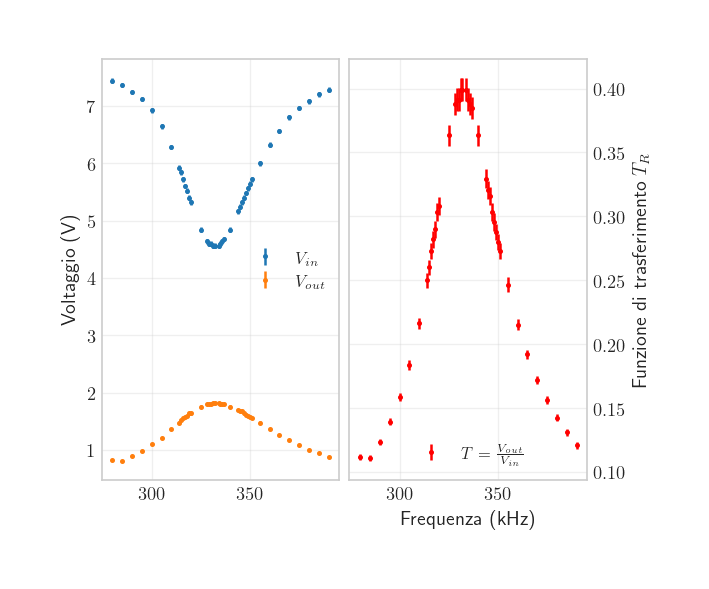

In [67]:
fig, ax = plt.subplots(1, 2, figsize=(5, 4), sharex=True, constrained_layout=True, width_ratios=[1, 1])
ax[0].errorbar(f_data, Vin_data, yerr=Vin_err, fmt='o', label=r'$V_{in}$', ms=2)
ax[0].errorbar(f_data, Vout_data, yerr=Vout_err, fmt='o', label=r'$V_{out}$', ms=2)
ax[0].legend(prop={'size': 10}, loc='best')
ax[0].set_ylabel(r'Voltaggio (V)')

ax[1].errorbar(f_data, Tr_data, yerr=Tr_err, fmt='o', label=r'$T=\frac{V_{out}}{V_{in}}$', ms=2, color='red')
ax[1].legend(prop={'size': 10}, loc='best')
ax[1].set_ylabel(r'Funzione di trasferimento $T_R$')
ax[1].set_xlabel(r'Frequenza (kHz)')
ax[1].yaxis.set_ticks_position('right')
ax[1].yaxis.set_label_position('right')

plt.savefig(f'../output/{project_name}_rawdata.png',
            bbox_inches="tight",
            pad_inches=1,
            transparent=True,
            facecolor="w",
            edgecolor='w',
            orientation='Portrait',
            dpi=100)

### Fit Function

In [68]:
def fitf(x, A, B, C):
    # Amplitude, B: resonant frequency, C: quality factor
    omega = 2.0 * np.pi * x * 1e3  # input in kHz
    fitval = A / np.sqrt(1+C**2*(omega/B-B/omega)**2)
    return fitval



### Initial estimate

In [69]:
Ainit= 0.4
Binit =  2.0 * np.pi *f0  # Hz
Cinit = Q

### First fit

In [70]:
popt, pcov = curve_fit(fitf, f_data, Tr_data, p0=[Ainit, Binit, Cinit], method='lm', sigma=Tr_err, absolute_sigma=True)
print("popt = ", popt)
print(popt[1]/(2*np.pi), "Hz")

popt =  [3.99371308e-01 2.09584472e+06 1.03484352e+01]
333564.0469653246 Hz


In [71]:
perr = np.sqrt(np.diag(pcov))
f0_fit = popt[1] / (2 * np.pi)  # Convert omega to frequency
f0_fit_err = perr[1] / (2 * np.pi)  # Convert omega error to frequency error

print('A = {a:.3f} +/- {b:.3f} \n f0 = {c:.3f} +/- {d:.3f} kHz \n Q = {e:.1f} +/- {f:.1f}'.format(
    a=popt[0], b=perr[0], c=f0_fit / 1000, d=f0_fit_err / 1000, e=popt[2], f=perr[2]))

residuals = Tr_data - fitf(f_data, *popt)
chisq = np.sum((residuals / Tr_err)**2)
df = len(f_data) - 3
chisq_red = chisq / df
print("chisq = ", chisq)
print("chisq_red = ", chisq_red)

A = 0.399 +/- 0.003 
 f0 = 333.564 +/- 0.141 kHz 
 Q = 10.3 +/- 0.1
chisq =  59.90795876262186
chisq_red =  1.5765252305953121


### Fit plot

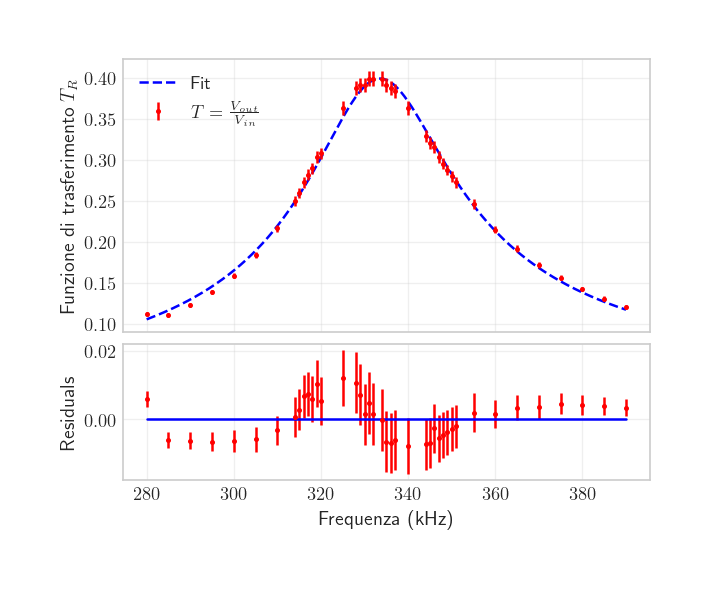

In [72]:
x_fit = np.linspace(min(f_data), max(f_data), 1000)

# Plot the fit
fig, ax = plt.subplots(2, 1, figsize=(5, 4), sharex=True, constrained_layout=True, height_ratios=[2, 1])
ax[0].plot(x_fit, fitf(x_fit, *popt), label='Fit', linestyle='--', color='blue')
#ax[0].plot(x_fit, fitf(x_fit, Ainit, Binit, Cinit), label='Initial Guess', linestyle='dashed', color='green')
ax[0].errorbar(f_data, Tr_data, yerr=Tr_err, fmt='o', label=r'$T=\frac{V_{out}}{V_{in}}$', ms=2, color='red')
ax[0].legend(loc='upper left')
ax[0].set_ylabel(r'Funzione di trasferimento $T_R$')

ax[1].errorbar(f_data, residuals, yerr=Tr_err, fmt='o', label='Residuals', ms=2, color='red')
ax[1].set_ylabel('Residuals')
ax[1].set_xlabel(r'Frequenza (kHz)')
ax[1].plot(f_data, np.zeros(len(f_data)), color='blue')

plt.savefig(f'../output/{project_name}_fit.png',
            bbox_inches="tight",
            pad_inches=1,
            transparent=True,
            facecolor="w",
            edgecolor='w',
            orientation='Portrait',
            dpi=100)


In [73]:
A_BF, B_BF, C_BF = popt 
eA_BF, eB_BF, eC_BF = np.sqrt(np.diag(pcov)) 

print("============== BEST FIT with SciPy ====================")
print(r'A = ({a:.3e} +/- {b:.1e})'.format(a=A_BF,b=eA_BF))
print(r'B = ({c:.5e} +/- {d:.1e}) kHz'.format(c=B_BF * 1e-3, d=eB_BF * 1e-3))
print(r'C = ({e:.3e} +/- {f:.1e})'.format(e=C_BF, f=eC_BF))
print(r'chisq = {m:.2f}'.format(m=chisq))
print(r'chisq_red = {m:.2f}'.format(m=chisq_red))
print("=======================================================")

============== BEST FIT with SciPy ====================
A = (3.994e-01 +/- 2.6e-03)
B = (2.09584e+03 +/- 8.8e-01) kHz
C = (1.035e+01 +/- 1.1e-01)
chisq = 59.91
chisq_red = 1.58


### Chi2 Profile

In [74]:
def fitchi2(i, j, k):
    x = f_data
    y = Tr_data
    y_err = Tr_err
    AA, BB, CC = A_chi[i], B_chi[j], C_chi[k]
    omega = 2.0 * np.pi * x * 1e3  # input in kHz
    residuals = (y - fitf(x, AA, BB, CC))  # Select fit function
    chi2 = np.sum((residuals / y_err) ** 2)
    mappa[i, j, k] = chi2


In [75]:
def profi2D(axis,matrix3D):
    if axis == 1 :
        mappa2D = np.array([[np.min(mappa[:,b,c]) for b in range(step)] for c in range(step)])
    if axis == 2 :
        mappa2D = np.array([[np.min(mappa[a,:,c]) for a in range(step)] for c in range(step)])
    if axis == 3 :
        mappa2D = np.array([[np.min(mappa[a,b,:]) for a in range(step)] for b in range(step)])
    return mappa2D

def profi1D(axis, mappa):
    if 1 in axis :
        mappa2D = np.array([[np.min(mappa[:,b,c]) for b in range(step)] for c in range(step)])
#        print('1')
        if 2 in axis:
            mappa1D = np.array([np.min(mappa2D[b,:]) for b in range(step)])
#            print('2')
        if 3 in axis:
            mappa1D = np.array([np.min(mappa2D[:,c]) for c in range(step)])
#            print('3')
    else :
#        print('2-3')
        mappa2D = np.array([[np.min(mappa[a,:,c]) for a in range(step)] for c in range(step)])
        mappa1D = np.array([np.min(mappa2D[a,:]) for a in range(step)])
    return mappa1D

In [76]:
NSI = 2  # Number of sigmas relative to the error from scipy
A0, A1 = A_BF - NSI * eA_BF, A_BF + NSI * eA_BF  # Scanning range for parameter A
B0, B1 = B_BF - NSI * eB_BF, B_BF + NSI * eB_BF  # Scanning range for parameter B
C0, C1 = C_BF - NSI * eC_BF, C_BF + NSI * eC_BF  # Scanning range for parameter C

step = 100  # Number of steps for the parameter grid
A_chi = np.linspace(A0, A1, step)  # Generate evenly spaced values for parameter A
B_chi = np.linspace(B0, B1, step)  # Generate evenly spaced values for parameter B
C_chi = np.linspace(C0, C1, step)  # Generate evenly spaced values for parameter C

# Initialize the 3D chi-squared matrix
mappa = np.zeros((step, step, step))

# Create a list of indices to map with the pool across multiple processors
item = [(i, j, k) for i in range(step) for j in range(step) for k in range(step)]

# Initialize the pool for parallel processing (up to 100 threads)
pool = multiprocessing.pool.ThreadPool(100)

# Map the 'item' list of indices to the fitchi2 function, which uses the parameter arrays
# and saves the chi-squared value in the correct position of the 3D matrix
pool.starmap(fitchi2, item, chunksize=10)

# Close the pool after processing
pool.close()

In [77]:
chi2_min = np.min(mappa)
argchi2_min = np.unravel_index(np.argmin(mappa),mappa.shape)

residuals_chi2 = Tr_data - fitf(f_data, A_chi[argchi2_min[0]], B_chi[argchi2_min[1]], C_chi[argchi2_min[2]])
chisq_res = np.sum((residuals_chi2 / Tr_err)**2)

print(chi2_min,argchi2_min, chisq_res)

59.90873231552167 (np.int64(50), np.int64(49), np.int64(50)) 59.90873231552167


### New Plot

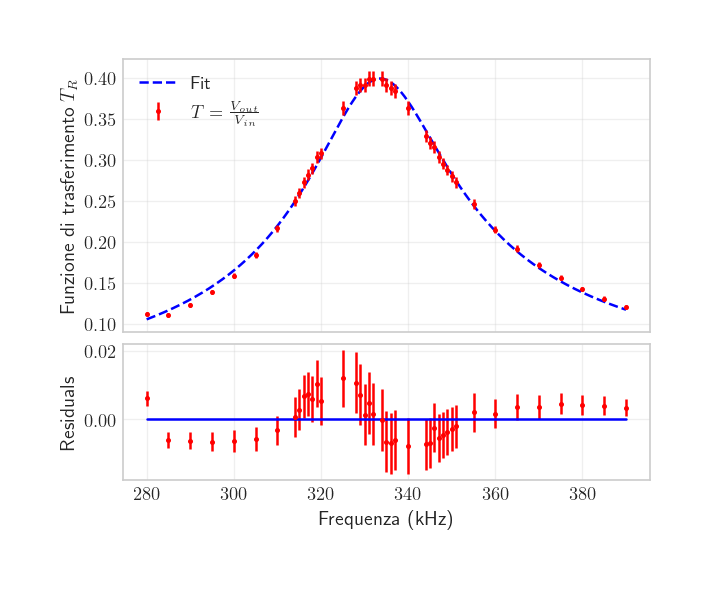

In [78]:
fig, ax = plt.subplots(2, 1, figsize=(5, 4),sharex=True, constrained_layout = True, height_ratios=[2, 1])
ax[0].plot(x_fit, fitf(x_fit, A_chi[argchi2_min[0]], B_chi[argchi2_min[1]], C_chi[argchi2_min[2]]), label='Fit', linestyle='--', color='blue')
# ax[0].plot(x_fit, fitf(x_fit, Ainit, Binit, Cinit), label='Initial Guess', linestyle='dashed', color='green')
ax[0].errorbar(f_data, Tr_data, yerr=Tr_err, fmt='o', label=r'$T=\frac{V_{out}}{V_{in}}$', ms=2, color='red')
ax[0].legend(loc='upper left')
ax[0].set_ylabel(r'Funzione di trasferimento $T_R$')

ax[1].errorbar(f_data, residuals_chi2, yerr=Tr_err, fmt='o', label='Residuals', ms=2, color='red')
ax[1].set_ylabel('Residuals')
ax[1].set_xlabel(r'Frequenza (kHz)')
ax[1].plot(f_data, np.zeros(len(f_data)), color='blue')

plt.savefig(f'../output/{project_name}_chi2_fit.png',
            bbox_inches="tight",
            pad_inches=1,
            transparent=True,
            facecolor="w",
            edgecolor='w',
            orientation='Portrait',
            dpi=100)


### Chi2 profile

In [79]:
chi2D = profi2D(1,mappa)

prof_B = profi1D([1,3],mappa)
prof_C = profi1D([1,2],mappa)   
prof_A = profi1D([2,3],mappa)  

lvl = chi2_min+1. # 2.3 (2parametri) # 3.8 (3parametri)
diff_B = abs(prof_B-lvl)
diff_C = abs(prof_C-lvl)
diff_A = abs(prof_A-lvl)

B_dx = np.argmin(diff_B[B_chi<B_BF]) # minimo di B per valori inferiori al BF
B_sx = np.argmin(diff_B[B_chi>B_BF])+len(diff_B[B_chi<B_BF]) # minimo di B per valori superiori al BF
C_dx = np.argmin(diff_C[C_chi<C_BF])
C_sx = np.argmin(diff_C[C_chi>C_BF])+len(diff_C[C_chi<C_BF])
A_dx = np.argmin(diff_A[A_chi<A_BF])
A_sx = np.argmin(diff_A[A_chi>A_BF])+len(diff_A[A_chi<A_BF])
#print(B_dx,B_sx,C_dx,C_sx,A_dx,A_sx)

# Facendo la differenza rispetto al BF ottengo gli errori a dx e a sx del BF
errA = A_chi[argchi2_min[0]]-A_chi[A_dx]
errAA = A_chi[A_sx]-A_chi[argchi2_min[0]]
errB = B_chi[argchi2_min[1]]-B_chi[B_dx] 
errBB = B_chi[B_sx] -B_chi[argchi2_min[1]]
errC = C_chi[argchi2_min[2]]-C_chi[C_dx]
errCC = C_chi[C_sx]-C_chi[argchi2_min[2]]


print("============== BEST FIT with chi2 ====================")
print(r'A = ({a:.3e} - {b:.1e} + {c:.1e})'.format(a=A_chi[argchi2_min[0]],b=errA,c=errAA))
print(r'B = ({d:.5e} - {e:.1e} + {f:.1e}) kHz'.format(d=B_chi[argchi2_min[1]] * 1e-3, e=errB * 1e-3, f=errBB* 1e-3))
print(r'C = ({g:.3e} - {h:.1e} + {n:.1e}) '.format(g=C_chi[argchi2_min[2]], h=errC,  n=errCC))
print(r'chisq = {m:.2f}'.format(m=np.min(mappa)))
print("=======================================================")


============== BEST FIT with chi2 ====================
A = (3.994e-01 - 2.6e-03 + 2.5e-03)
B = (2.09583e+03 - 8.6e-01 + 8.9e-01) kHz
C = (1.035e+01 - 1.1e-01 + 1.1e-01) 
chisq = 59.91


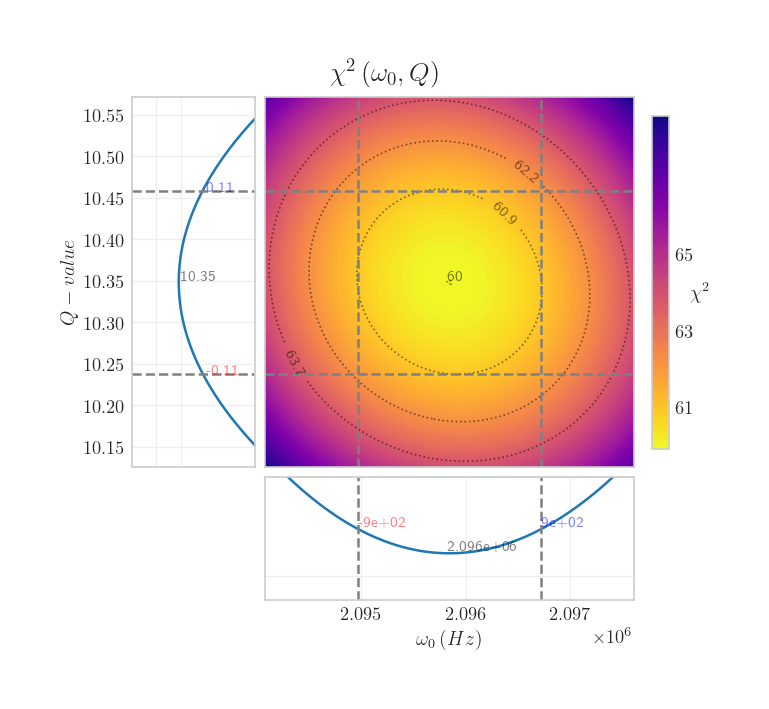

In [80]:
# Define the color map
color_map = mpl.colormaps['plasma'].reversed()
levels = np.linspace(np.min(chi2D), np.max(chi2D), 100)
line_color = 'gray'

# Profiling of Omega and Q
fig, ax = plt.subplots(2, 2, figsize=(5.5, 5), constrained_layout=True, height_ratios=[3, 1], width_ratios=[1, 3], sharex='col', sharey='row')
fig.suptitle(r'$\chi^2 \left(\omega_0, Q \right)$')

# Contour plot
im = ax[0, 1].contourf(B_chi, C_chi, chi2D, levels=levels, cmap=color_map)
cbar = fig.colorbar(im, extend='both', shrink=0.9, ax=ax[0, 1], ticks=[int(chi2_min), int(chi2_min + 2), int(chi2_min + 4), int(chi2_min + 6)])
cbar.set_label(r'$\chi^2$', rotation=360)

# Contour lines
CS = ax[0, 1].contour(B_chi, C_chi, chi2D, levels=[chi2_min + 0.0001, chi2_min + 1, chi2_min + 2.3, chi2_min + 3.8], linewidths=1, colors='k', alpha=0.5, linestyles='dotted')
ax[0, 1].clabel(CS, inline=True, fontsize=9, fmt='%.1f')
ax[0, 1].text(B_chi[np.argmin(prof_B)], C_chi[np.argmin(prof_C)], r'{g:.0f}'.format(g=chi2_min), color='k', alpha=0.5, fontsize=9)

# Dashed lines for bounds
ax[0, 1].plot([B0, B1], [C_chi[C_sx], C_chi[C_sx]], color=line_color, ls='dashed')
ax[0, 1].plot([B0, B1], [C_chi[C_dx], C_chi[C_dx]], color=line_color, ls='dashed')
ax[0, 1].plot([B_chi[B_sx], B_chi[B_sx]], [C0, C1], color=line_color, ls='dashed')
ax[0, 1].plot([B_chi[B_dx], B_chi[B_dx]], [C0, C1], color=line_color, ls='dashed')

# Profile plot for Q
ax[0, 0].plot(prof_B, C_chi, ls='-')
ax[0, 0].plot([int(chi2_min - 1), int(chi2_min + 4)], [C_chi[C_sx], C_chi[C_sx]], color=line_color, ls='dashed')
ax[0, 0].plot([int(chi2_min - 1), int(chi2_min + 4)], [C_chi[C_dx], C_chi[C_dx]], color=line_color, ls='dashed')

ax[0, 0].set_xticks([int(chi2_min), int(chi2_min + 1), int(chi2_min + 4), int(chi2_min + 6)])
ax[0, 0].text(int(chi2_min + 1), C_chi[np.argmin(prof_C)], r'{g:.2f}'.format(g=C_chi[np.argmin(prof_C)]), color='k', alpha=0.5, fontsize=9)
ax[0, 0].text(int(chi2_min + 2), C_chi[C_sx], r'{g:.2f}'.format(g=errCC), color='b', alpha=0.5, fontsize=9)
ax[0, 0].text(int(chi2_min + 2), C_chi[C_dx], r'{g:.2f}'.format(g=-1 * errC), color='r', alpha=0.5, fontsize=9)

# Profile plot for Omega
ax[1, 1].plot(B_chi, prof_C)
ax[1, 1].plot([B_chi[B_sx], B_chi[B_sx]], [int(chi2_min - 1), int(chi2_min + 4)], color=line_color, ls='dashed')
ax[1, 1].plot([B_chi[B_dx], B_chi[B_dx]], [int(chi2_min - 1), int(chi2_min + 4)], color=line_color, ls='dashed')

ax[1, 1].text(B_chi[np.argmin(prof_B)], int(chi2_min + 1), r'{g:.3e}'.format(g=B_chi[np.argmin(prof_B)]), color='k', alpha=0.5, fontsize=9)
ax[1, 1].text(B_chi[B_sx], int(chi2_min + 2), r'{g:.0e}'.format(g=errBB), color='b', alpha=0.5, fontsize=9)
ax[1, 1].text(B_chi[B_dx], int(chi2_min + 2), r'{g:.0e}'.format(g=-1 * errB), color='r', alpha=0.5, fontsize=9)
ax[1, 1].set_yticks([int(chi2_min), int(chi2_min + 4), int(chi2_min + 6)])

# Turn off unused subplot
ax[1, 0].set_axis_off()

# Set labels and limits
ax[0, 0].set_ylabel(r'$Q-value$')
ax[1, 1].set_xlabel(r'$\omega_0\left(Hz\right)$', loc='center')
ax[0, 0].set_xlim(int(chi2_min - 1), int(chi2_min + 4))
ax[1, 1].set_ylim(int(chi2_min - 1), int(chi2_min + 4))

# Save the plot
plt.savefig(f'../output/{project_name}_chi2_map.png',
            bbox_inches="tight",
            pad_inches=1,
            transparent=True,
            facecolor="w",
            edgecolor='w',
            orientation='Portrait',
            dpi=100)

# Phase

### Fit Function


In [81]:
def fitphase(x, B, C):
    # Amplitude, B: resonant frequency, C: quality factor
    omega = 2.0 * np.pi * x * 1e3  # input in kHz
    fitval = np.arctan(C*(omega/B-B/omega))/(np.pi/2) # norm to 1
    return fitval

### Plot Raw

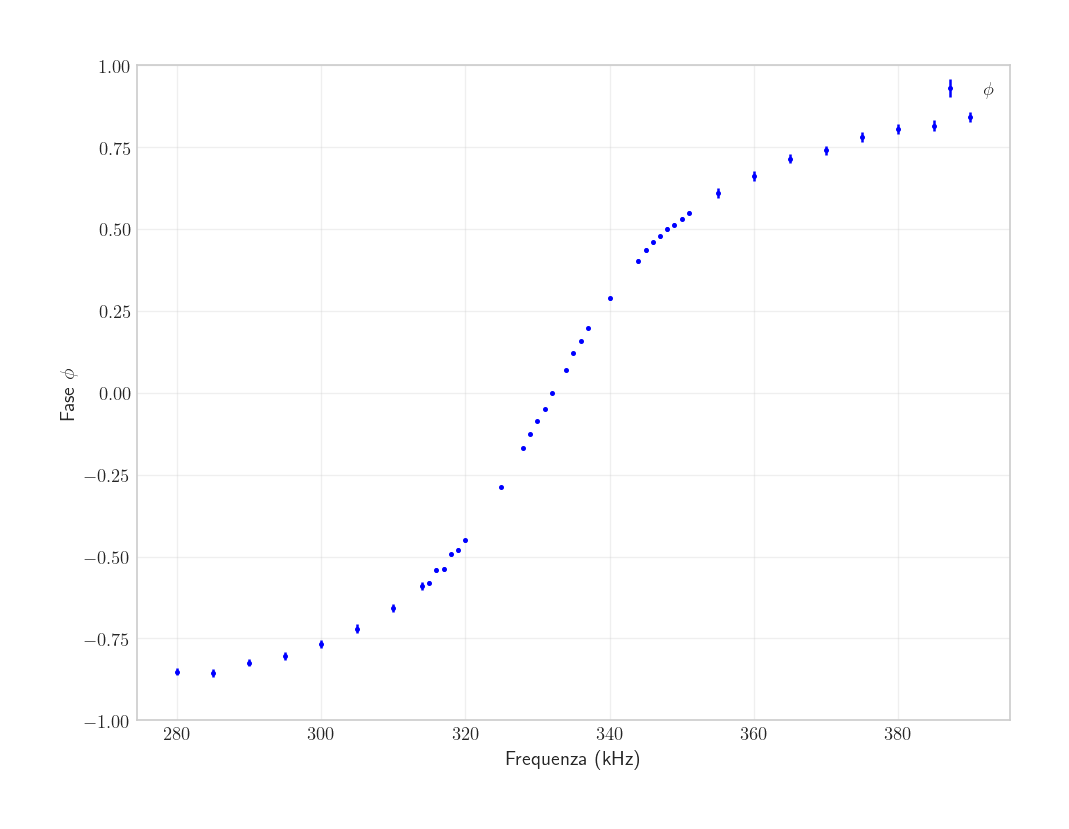

In [82]:
fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)

ax.errorbar(f_data, phi_data, yerr=phi_err, fmt='o', label=r'$\phi$', ms=2, color='blue')
ax.set_xlabel(r'Frequenza (kHz)')
ax.set_ylabel(r'Fase $\phi$')
ax.set_ylim(-1, 1)  #
ax.legend(loc='best')

plt.savefig(f'../output/{project_name}_phi_data.png',
            bbox_inches="tight",
            pad_inches=1,
            transparent=True,
            facecolor="w",
            edgecolor='w',
            orientation='Portrait',
            dpi=100)

In [83]:
# Fit dei dati di fase
popt_phi, pcov_phi = curve_fit(fitphase, f_data, phi_data, p0=[Binit, Cinit], sigma=phi_err, absolute_sigma=True)

# Calcolo degli errori sui parametri
perr_phi = np.sqrt(np.diag(pcov_phi))
f0_fit_phi = popt_phi[0] / (2 * np.pi)  # Convert omega to frequency
f0_fit_phi_err = perr_phi[0] / (2 * np.pi)  # Convert omega error to frequency error

# Stampa dei risultati
print('f0 = {f:.3f} +/- {fe:.3f} kHz \n Q = {q:.1f} +/- {qe:.1f}'.format(
    f=f0_fit_phi / 1000, fe=f0_fit_phi_err / 1000, q=popt_phi[1], qe=perr_phi[1]))

# Calcolo dei residui e del chi-quadro
residuals_phi = phi_data - fitphase(f_data, *popt_phi)
chisq_phi = np.sum((residuals_phi / phi_err)**2)
df_phi = len(f_data) - len(popt_phi)  # Gradi di libertà
chisq_red_phi = chisq_phi / df_phi

# Stampa del chi-quadro
print("chisq = ", chisq_phi)
print("chisq_red = ", chisq_red_phi)


print("========== BEST FIT using phase with SciPy ============")
print(r'B = ({c:.5e} +/- {d:.1e}) kHz'.format(c=popt_phi[0] * 1e-3, d=perr_phi[0] * 1e-3))
print(r'C = ({e:.3e} +/- {f:.1e})'.format(e=popt_phi[1], f=perr_phi[1]))
print(r'chisq = {m:.2f}'.format(m=chisq_phi))
print(r'chisq_red = {m:.2f}'.format(m=chisq_red_phi))
print("=======================================================")

f0 = 332.152 +/- 0.013 kHz 
 Q = 11.0 +/- 0.0
chisq =  252.7497276675185
chisq_red =  6.48076224788509
========== BEST FIT using phase with SciPy ============
B = (2.08697e+03 +/- 8.1e-02) kHz
C = (1.104e+01 +/- 3.6e-02)
chisq = 252.75
chisq_red = 6.48


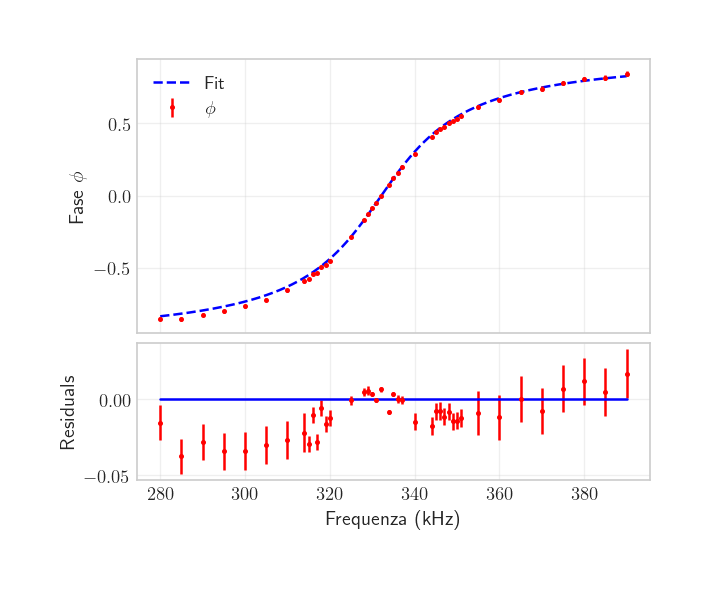

In [84]:
# Creazione del grafico del fit della fase
fig, ax = plt.subplots(2, 1, figsize=(5, 4), sharex=True, constrained_layout=True, height_ratios=[2, 1])

# Grafico del fit
ax[0].plot(x_fit, fitphase(x_fit, *popt_phi), label='Fit', linestyle='--', color='blue')
ax[0].errorbar(f_data, phi_data, yerr=phi_err, fmt='o', label=r'$\phi$', ms=2, color='red')
ax[0].legend(loc='upper left')
ax[0].set_ylabel(r'Fase $\phi$')

# Grafico dei residui
ax[1].errorbar(f_data, residuals_phi, yerr=phi_err, fmt='o', label='Residuals', ms=2, color='red')
ax[1].set_ylabel('Residuals')
ax[1].set_xlabel(r'Frequenza (kHz)')
ax[1].plot(f_data, np.zeros(len(f_data)), color='blue')

# Salvataggio del grafico
plt.savefig(f'../output/{project_name}_phi_fit.png',
            bbox_inches="tight",
            pad_inches=1,
            transparent=True,
            facecolor="w",
            edgecolor='w',
            orientation='Portrait',
            dpi=100)

# Linear Fit breakpoint Frequency

In [85]:
def linear_fit(x, m, q):
    return m * x + q

In [86]:
Tr_max = np.max(Tr_data)
Tr_12 = Tr_max / np.sqrt(2)
Tr_12_err = Tr_err[np.argmax(Tr_data)] / np.sqrt(2)
print("Tr_12 = ", Tr_12, " +/- ", Tr_12_err)

Tr_data1 = Tr_data[(f_data > 313) & (f_data < 321)]  # linear interval around f1
Tr_data2 = Tr_data[(f_data > 343) & (f_data < 352)]  # linear interval around f2
f_data1 = f_data[(f_data > 313) & (f_data < 321)]  # linear interval around f1
f_data2 = f_data[(f_data > 343) & (f_data < 352)]  # linear interval around f2
Tr_err1 = Tr_err[(f_data > 313) & (f_data < 321)]  # linear interval around f1
Tr_err2 = Tr_err[(f_data > 343) & (f_data < 352)]  # linear interval around f2
print(f_data1)

Tr_12 =  0.28222244336831503  +/-  0.006375316523081041
[314. 315. 316. 317. 318. 319. 320.]


In [96]:
popt1, pcov1 = curve_fit(linear_fit, f_data1, Tr_data1, p0=[0.01, 0.01], sigma=Tr_err1, absolute_sigma=True)
popt2, pcov2 = curve_fit(linear_fit, f_data2, Tr_data2, p0=[0.01, 0.01], sigma=Tr_err2, absolute_sigma=True)
perr1 = np.sqrt(np.diag(pcov1))
perr2 = np.sqrt(np.diag(pcov2))

print("popt1 = ", popt1)
print("popt2 = ", popt2)
print("perr1 = ", perr1)
print("perr2 = ", perr2)

# Calculate chi-squared for the two fits
residuals1 = Tr_data1 - linear_fit(f_data1, *popt1)
residuals2 = Tr_data2 - linear_fit(f_data2, *popt2)

chisq1 = np.sum((residuals1 / Tr_err1) ** 2)
chisq2 = np.sum((residuals2 / Tr_err2) ** 2)
df1 = len(f_data1) - len(popt1)  # Degrees of freedom for fit 1
df2 = len(f_data2) - len(popt2)  # Degrees of freedom for fit 2
print("df1 = ", df1)
print("df2 = ", df2)
print("chisq1 = ", chisq1)
print("chisq2 = ", chisq2)

popt1 =  [ 0.01000729 -2.89132624]
popt2 =  [-0.00822026  3.15726076]
perr1 =  [0.00121267 0.3841134 ]
perr2 =  [0.00105453 0.36673515]
df1 =  5
df2 =  6
chisq1 =  0.48604192877386254
chisq2 =  0.22816340690125297


In [ ]:
# m*f1 + q = Tr12

f1 = (Tr_12-popt1[1])/popt1[0]
f2 = (Tr_12-popt2[1])/popt2[0]

print("f1 = ", f1, "kHz")
print("f2 = ", f2, "kHz")
# Error propagation for f1 and f2
f1_err = np.sqrt((Tr_12_err / popt1[0])**2 + ((Tr_12 - popt1[1]) * perr1[0] / (popt1[0]**2))**2 + (perr1[1] / popt1[0])**2)
f2_err = np.sqrt((Tr_12_err / popt2[0])**2 + ((Tr_12 - popt2[1]) * perr2[0] / (popt2[0]**2))**2 + (perr2[1] / popt2[0])**2)

print("f1_err = ", f1_err, "kHz")
print("f2_err = ", f2_err, "kHz")



f1 =  317.1236594354859 kHz
f2 =  349.75023784638444 kHz
f1_err =  54.317960858219145 kHz
f2_err =  63.27766101371112 kHz


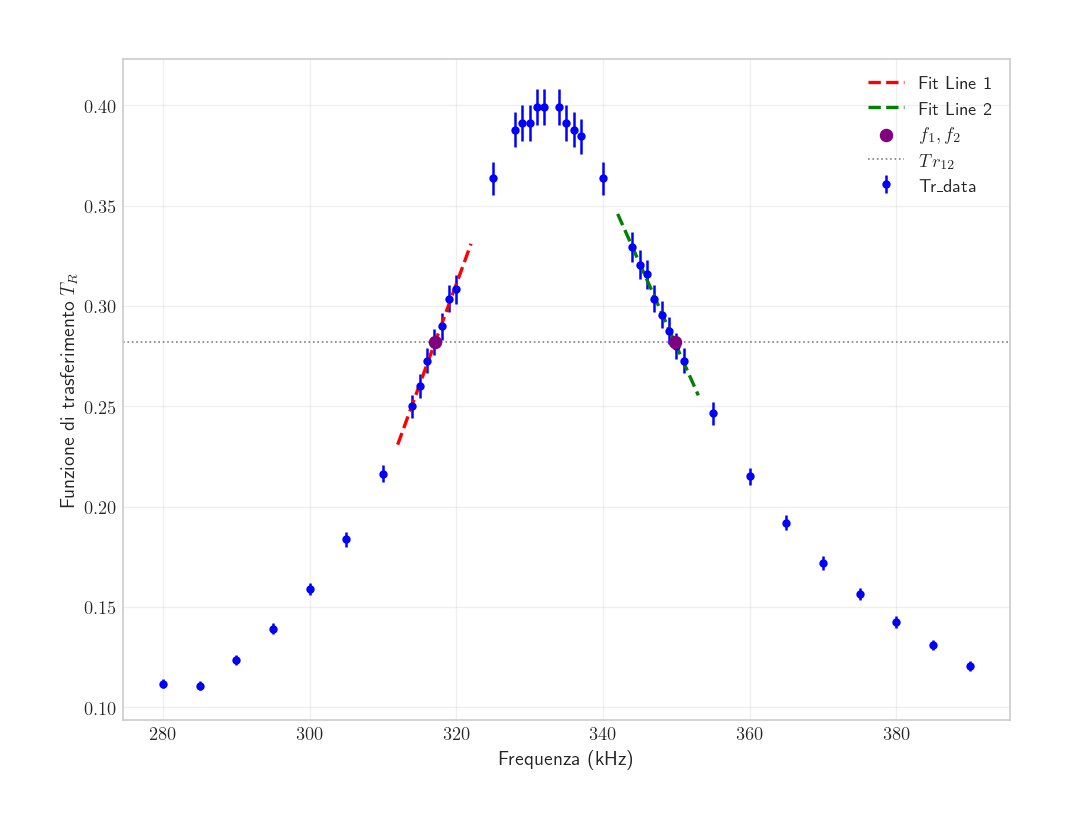

In [89]:
# Creazione del grafico
fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)

# Plot dei dati di Tr_data
ax.errorbar(f_data, Tr_data, yerr=Tr_err, fmt='o', label='Tr_data', ms=4, color='blue')

# Plot della prima retta
x_fit1 = np.linspace(min(f_data1) - 2, max(f_data1) + 2, 100)  # Estensione della lunghezza ridotta
y_fit1 = linear_fit(x_fit1, *popt1)
ax.plot(x_fit1, y_fit1, label='Fit Line 1', color='red', linestyle='--', linewidth=2)

# Plot della seconda retta
x_fit2 = np.linspace(min(f_data2) - 2, max(f_data2) + 2, 100)  # Estensione della lunghezza ridotta
y_fit2 = linear_fit(x_fit2, *popt2)
ax.plot(x_fit2, y_fit2, label='Fit Line 2', color='green', linestyle='--', linewidth=2)

# Inserimento dei punti f1, Tr12 e f2, Tr12
ax.scatter([f1, f2], [Tr_12, Tr_12], color='purple', label=r'$f_1, f_2$', zorder=5, s=50)  # Dimensione aumentata
ax.axhline(Tr_12, color='gray', linestyle='dotted', linewidth=1, label=r'$Tr_{12}$')

# Etichette e legenda
ax.set_xlabel('Frequenza (kHz)')
ax.set_ylabel('Funzione di trasferimento $T_R$')
ax.legend(loc='best')

# Salvataggio del grafico
plt.savefig(f'../output/{project_name}_tr_fit_lines.png',
            bbox_inches="tight",
            pad_inches=1,
            transparent=True,
            facecolor="w",
            edgecolor='w',
            orientation='Portrait',
            dpi=100)

### Linear Fit Phase

In [90]:
f_data3 = f_data[(f_data > 327) & (f_data < 338)]  # linear interval around f0
phi_data3 = phi_data[(f_data > 327) & (f_data < 338)]  # linear interval around f0
phi_err3 = phi_err[(f_data > 327) & (f_data < 338)]  # linear interval around f0

In [91]:
popt3, pcov3 = curve_fit(linear_fit, f_data3, phi_data3, p0=[0.01, 0.01], sigma=phi_err3, absolute_sigma=True)
perr3 = np.sqrt(np.diag(pcov3))
print("popt3 = ", popt3)
print("perr3 = ", perr3)

popt3 =  [  0.04082202 -13.55815521]
perr3 =  [0.00023578 0.07837276]


In [92]:
f3 = (-popt3[1])/popt3[0]
print("f3 = ", f3, "kHz")  
# Error propagation for f3
f3_err = np.sqrt((perr3[1] / popt3[0])**2 + ((popt3[1]) * perr3[0] / (popt3[0]**2))**2)
print("f3_err = ", f3_err, "kHz")

f3 =  332.12848090458556 kHz
f3_err =  2.714024826659769 kHz
